# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
I am planning to analyze the content of interpellations from the Legislative Yuan in Taiwan. The Legislative Yuan is a counterpart of U.S. Congress in Taiwan Politics. In Legislative Yuan, one duty of legislators (Congressmen) is to challenge government officials. The topics of these interpellations range from economy, education to local events, and can usually be a good indicator of the legislative bills each political party is going to propose.

## ***Why?***
Although Legislative Yuan provides an open platform on which people can access the texts and videos of individual interpellations, there is currently no large-scale investigation on these contents. Analyzing content of interpellations does not only help provide a better insight into the natures of different political parties in Taiwan (for example, the issues each political party is most concerned with over time), but also facilitate the study of legislative branch and its role in separation of powers.

## ***How?***
1.	Data Collection:
•	The main content to be analyzed is texts of interpellations, which can be accessed using an API provided by Legislative Yuan.
•	Data on legislative bills will also be collected through Legislative Yuan API.
•	Other contents, such as news articles in Taiwan, and Laws in Taiwan, may also be collected. (through web scraping)
2.	Sampling:
     All texts from interpellations are likely to be directly relevant to the research, and thus should not be excluded. The unit of record for the main content is interpellation, but the unit of analysis can be either legislator or political party (no party will be considered a single party).
3.	Data Analysis:
Because the research is highly concerned with categorizing the interpellations, the immediate data analysis approaches applicable would be k-means clustering and topic modeling. However, these two approaches have a common problem: the clusters/topics are automatically generated using machine learning and cannot be manually specified.
Ideally, we want the content to interpellations to be classified into eight categories, namely ‘内政’ (Internal Administration), ‘社会福利及卫生环境’ (Social Welfare and Environmental Hygiene), ‘司法’ (Judiciary and Organic Laws and Statute), ‘交通’ (Transportation), ‘教育及文化’ (Education and Culture), ‘财政’ (Finance), ‘经济’ (Economics) and ‘外交与国防’ (Foreign and National Defense). This set of categories is not only aligned with the standing committees within Legislative Yuan, but is also in consistent with the categorization of Laws in Taiwan.
One possible way to achieve this goal is to train the k-means clustering model on vectors of frequencies (conditional frequencies/co-presence, etc.) of pre-specified words/n-grams. Hopefully, the tools from classification (week 6) will be useful for the project.
After successfully classifying the documents, I need to calculate the weight of each topic for each party. These weights will first be compared across different parties, and a predictive model will be built to predict the party affiliation of legislators based on their aggregated content of interpellation. After that, a longitudinal analysis will be performed to identify patterns of changes.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
The sample design allows us to make inferences on the focused issues of political parties in Taiwan. Specifically, content of interpellations has two central characteristics that can facilitate our understanding of political parties. First, unlike press releases or words of spokesmen, interpellations are usually less closely examined by the public and the media, and therefore these interpellations can be much more straightforward or personal reflections of political standings. Moreover, the congressmen/legislators are usually key members of political parties, and thus can be highly representative of their parties.

However, there are also some limitations associated with the sample design. An important one is that there is probably not a ‘unbiased/neutral’ standard that we can compare these parties with. Therefore, the characteristics of each political party can be discussed only when compared to another. A reasonable extension of this project is to build a model to predict the behavior of these legislators/political parties, especially in the context of proposing legislative bills. For example, if an issue is mentioned with high frequency in interpellations by a legislator/party, then there might be a decent chance that the legislator/party will propose a legislative bill related to the issue/topic.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

In [38]:
Int0901DF = pandas.read_csv('../data/6_CSV_6_0901CSV-1.csv')
Int0902DF = pandas.read_csv('../data/6_CSV_6_0902CSV-1.csv')
Int09DF = pandas.concat([Int0901DF,Int0902DF])
Int09DF.head()

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5
0,9,1,1,一、本院徐委員榛蔚，鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗...,901,NaN
1,9,1,1,二、本院徐委員榛蔚，針對今（105）年2月6日南台強震，台南地區因盲斷層影響，產生「震源效應...,901,NaN
2,9,1,1,三、本院徐委員榛蔚，針對台9線蘇花公路山區路段改善計畫（以下簡稱蘇花改計畫）究其根柢，係一「...,901,NaN
3,9,1,1,四、本院徐委員榛蔚，有鑑於每逢農曆年假鐵公路運輸量暴增，復因今（105）年農曆新年發生芮氏規...,901,NaN
4,9,1,1,五、本院鄭委員麗君，就國立中興大學徵「零元講師」乙事，特向行政院提出質詢。,901,NaN


In [39]:
#legislator name
def extract_name(string):
    name_str = string.split('、')[1].replace('本院','').replace('委員','')
    return name_str

Int09DF['name'] = Int09DF['item'].str.split("，").apply(lambda x: x[0])
Int09DF['name'] = Int09DF['name'].apply(extract_name)

#clean interpellation content
def clean_content(content):
    cleaned_content = '，'.join(content.split('，')[1:])
    return cleaned_content

Int09DF['clean item'] = Int09DF['item'].apply(clean_content)

In [40]:
import jieba.analyse
import jieba

jieba.set_dictionary('../data/dict.txt.big.txt')
jieba.load_userdict('../data/AdditionalWords.txt')

Int09DF['segmented_words'] = Int09DF['clean item'].apply(jieba.lcut)
Int09DF['joined_text'] = Int09DF['segmented_words'].apply(" ".join)

Int09DF[:2]

Building prefix dict from /home/lingdai/content-analysis-2018/data/dict.txt.big.txt ...
Loading model from cache /tmp/jieba.u2ed7f306195aa74fd365f7c489494496.cache
Loading model cost 1.499 seconds.
Prefix dict has been built succesfully.


,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,joined_text
0,9,1,1,一、本院徐委員榛蔚，鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗...,901,NaN,徐榛蔚,鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗震標準，然於民國88...,"[鑑於, 我國, 建築, 技術, 及, 橋樑, 規範, 於, 921, 地震, 之後, ，,...",鑑於 我國 建築 技術 及 橋樑 規範 於 921 地震 之後 ， 重新制定 耐震 係數 ，...
1,9,1,1,二、本院徐委員榛蔚，針對今（105）年2月6日南台強震，台南地區因盲斷層影響，產生「震源效應...,901,NaN,徐榛蔚,針對今（105）年2月6日南台強震，台南地區因盲斷層影響，產生「震源效應」及「場址效應」，導...,"[針對, 今, （, 105, ）, 年, 2, 月, 6, 日, 南台, 強震, ，, 台...",針對 今 （ 105 ） 年 2 月 6 日 南台 強震 ， 台南 地區 因盲 斷層 影響 ...


In [42]:
#Initialize
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Train
LYVects = ngCountVectorizer.fit_transform(Int09DF['joined_text'])

LYTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(LYVects)
#train
LYTF = LYTFTransformer.transform(LYVects)
# -*- coding: utf-8 -*-

#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5,max_features=3000, min_df=3,
                                                                 stop_words=stopwords.words('english'), norm='l2')
#train
LYTFVects = ngTFVectorizer.fit_transform(Int09DF['joined_text'])

In [44]:
#K-Means Clustering

import sklearn.cluster

numClusters = 8
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(LYTFVects)

#assign predicted class
Int09DF['kmeans_predictions'] = km.labels_

In [46]:
#Top Terms of Each Cluster

terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 產業
 發展
 台灣
 投資
 經濟
 創新
 政府
 轉型
 企業
 人才


Cluster 1:
 社會
 長照
 高齡
 毒品
 照顧
 問題
 警察
 照護
 鑒於
 發生


Cluster 2:
 學生
 教育
 學校
 教育部
 校園
 教師
 大學
 助理
 動物
 教官


Cluster 3:
 經濟
 台灣
 政府
 我國
 美國
 政策
 國際
 鑒於
 全球
 要求


Cluster 4:
 醫療
 疫情
 流感
 健康
 國人
 垃圾
 健保
 院所
 衛福部
 護理人員


Cluster 5:
 勞工
 制度
 基金
 勞動部
 年金
 改革
 一案
 針對
 權益
 勞動


Cluster 6:
 相關
 針對
 我國
 要求
 民眾
 事件
 建請
 政府
 鑒於
 單位


Cluster 7:
 交通
 安全
 地區
 居民
 交通部
 公司
 運輸
 花東
 發展
 高雄




In [90]:
#According to the clustering results above, we drop all the documents
#that are not classified into cluster 0 or 3 (Related to 'Economy' according to keywords).

SubInt09DF = Int09DF[(Int09DF['kmeans_predictions'] == 0)|(Int09DF['kmeans_predictions'] == 3)] 

#Number of documents in the sample
print(len(SubInt09DF))

291


In [91]:
#Word Frequency
def WordFreq(WordList, TargetWord):
    wordCount = 0
    for w in WordList:
        if w == TargetWord:
            wordCount += 1
    return wordCount/len(WordList)

SubInt09DF['target_word_freq'] = SubInt09DF['segmented_words'].apply(WordFreq, TargetWord ='創新')

SubInt09DF['target_word_freq'].mean()

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0.001298369378828809

In [92]:
SubInt09DF = SubInt09DF[SubInt09DF['target_word_freq'] > 0.001] 

#Number of documents in the sample
print(len(SubInt09DF))

29


In [93]:
SubInt09DF[:1]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,joined_text,kmeans_predictions,target_word_freq
156,9,1,6,三十二、本院許委員淑華，鑒於歐洲央行（ECB）總裁德拉基日前宣布將歐元區的基準利率，從原本的...,901,NaN,許淑華,鑒於歐洲央行（ECB）總裁德拉基日前宣布將歐元區的基準利率，從原本的0.05%下調到零，其他...,"[鑒於, 歐洲央行, （, ECB, ）, 總裁, 德拉, 基, 日前, 宣布, 將, 歐元...",鑒於 歐洲央行 （ ECB ） 總裁 德拉 基 日前 宣布 將 歐元區 的 基準利率 ， 從...,0,0.007692


In [80]:
#Topic modeling
import gensim

dictionary = gensim.corpora.Dictionary(SubInt09DF['segmented_words'])
corpus = [dictionary.doc2bow(text) for text in SubInt09DF['segmented_words']]

Intlda = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,
                                         num_topics=4, alpha='auto', eta='auto')

In [88]:
ldaDF = pandas.DataFrame({
        'item' : SubInt09DF['clean item'],
        'topics' : [Intlda[dictionary.doc2bow(l)] for l in SubInt09DF['segmented_words']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(Intlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(Intlda.num_topics):
    SubInt09DF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

SubInt09DF[:2]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,joined_text,kmeans_predictions,target_word_freq,topics,topic_0,topic_1,topic_2,topic_3
156,9,1,6,三十二、本院許委員淑華，鑒於歐洲央行（ECB）總裁德拉基日前宣布將歐元區的基準利率，從原本的...,901,NaN,許淑華,鑒於歐洲央行（ECB）總裁德拉基日前宣布將歐元區的基準利率，從原本的0.05%下調到零，其他...,"[鑒於, 歐洲央行, （, ECB, ）, 總裁, 德拉, 基, 日前, 宣布, 將, 歐元...",鑒於 歐洲央行 （ ECB ） 總裁 德拉 基 日前 宣布 將 歐元區 的 基準利率 ， 從...,0,0.007692,"[(3, 0.9887243)]",0.0,0.0,0.0,0.988717
167,9,1,6,四十三、本院黃委員昭順，針對「物聯網」世紀的來臨已是必然，但請問政府；面對即臨的科技產業變革...,901,NaN,黃昭順,針對「物聯網」世紀的來臨已是必然，但請問政府；面對即臨的科技產業變革，是否已足以因應與掌握？...,"[針對, 「, 物聯網, 」, 世紀, 的, 來臨, 已, 是, 必然, ，, 但, 請問,...",針對 「 物聯網 」 世紀 的 來臨 已 是 必然 ， 但 請問 政府 ； 面對 即臨 的 ...,0,0.003344,"[(3, 0.9953976)]",0.0,0.0,0.0,0.995397


In [89]:
SubInt09DF = SubInt09DF[SubInt09DF['topic_3'] < 0.5] 

#Number of documents in the sample
print(len(SubInt09DF))

15


In [96]:
SubInt09DF

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,joined_text,kmeans_predictions,target_word_freq
156,9,1,6,三十二、本院許委員淑華，鑒於歐洲央行（ECB）總裁德拉基日前宣布將歐元區的基準利率，從原本的...,901,NaN,許淑華,鑒於歐洲央行（ECB）總裁德拉基日前宣布將歐元區的基準利率，從原本的0.05%下調到零，其他...,"[鑒於, 歐洲央行, （, ECB, ）, 總裁, 德拉, 基, 日前, 宣布, 將, 歐元...",鑒於 歐洲央行 （ ECB ） 總裁 德拉 基 日前 宣布 將 歐元區 的 基準利率 ， 從...,0,0.007692
167,9,1,6,四十三、本院黃委員昭順，針對「物聯網」世紀的來臨已是必然，但請問政府；面對即臨的科技產業變革...,901,NaN,黃昭順,針對「物聯網」世紀的來臨已是必然，但請問政府；面對即臨的科技產業變革，是否已足以因應與掌握？...,"[針對, 「, 物聯網, 」, 世紀, 的, 來臨, 已, 是, 必然, ，, 但, 請問,...",針對 「 物聯網 」 世紀 的 來臨 已 是 必然 ， 但 請問 政府 ； 面對 即臨 的 ...,0,0.003344
369,9,1,15,十一、本院許委員淑華，鑑於台灣近年薪資成長停滯，與國內投資不振有極大的關係。民間投資已經連續...,901,NaN,許淑華,鑑於台灣近年薪資成長停滯，與國內投資不振有極大的關係。民間投資已經連續十五年處於停滯狀態，固...,"[鑑於, 台灣, 近年, 薪資, 成長, 停滯, ，, 與, 國內, 投資, 不振, 有, ...",鑑於 台灣 近年 薪資 成長 停滯 ， 與 國內 投資 不振 有 極大 的 關係 。 民間 ...,0,0.009901
374,9,1,15,十六、本院黃委員昭順，針對政府將放寬外籍人士移民限制，並由求學階段開始吸引優秀人才來台就學，...,901,NaN,黃昭順,針對政府將放寬外籍人士移民限制，並由求學階段開始吸引優秀人才來台就學，為國家廣納人才，深表認...,"[針對, 政府, 將, 放寬, 外籍人士, 移民, 限制, ，, 並由, 求學, 階段, 開...",針對 政府 將 放寬 外籍人士 移民 限制 ， 並由 求學 階段 開始 吸引 優秀人才 來台...,0,0.004016
398,9,1,17,五、本院蔡委員培慧，鑑於台灣位處亞熱帶氣候，適合蝴蝶蘭生長，又有優良育種技術，然據台灣蘭花產...,901,NaN,蔡培慧,鑑於台灣位處亞熱帶氣候，適合蝴蝶蘭生長，又有優良育種技術，然據台灣蘭花產銷發展協會資料顯示，...,"[鑑於, 台灣, 位處, 亞熱帶, 氣候, ，, 適合, 蝴蝶蘭, 生長, ，, 又, 有,...",鑑於 台灣 位處 亞熱帶 氣候 ， 適合 蝴蝶蘭 生長 ， 又 有 優良 育種 技術 ， 然...,0,0.005076
405,9,1,17,十二、本院黃委員昭順，針對新政府積極推動產業政策的企圖心，甚表讚許，但切莫忘了政府是個團隊而...,901,NaN,黃昭順,針對新政府積極推動產業政策的企圖心，甚表讚許，但切莫忘了政府是個團隊而非個人秀；未經審慎評估...,"[針對, 新政府, 積極, 推動, 產業政策, 的, 企圖心, ，, 甚表, 讚許, ，, ...",針對 新政府 積極 推動 產業政策 的 企圖心 ， 甚表 讚許 ， 但 切莫 忘 了 政府 ...,0,0.006369
543,9,1,19,二十二、本院許委員淑華，針對台灣股后、半導體電子束檢測設備龍頭廠商漢微科將100%股權以每股...,901,NaN,許淑華,針對台灣股后、半導體電子束檢測設備龍頭廠商漢微科將100%股權以每股1410元、總價約新台幣...,"[針對, 台灣, 股后, 、, 半導體, 電子束, 檢測, 設備, 龍頭, 廠商, 漢微, ...",針對 台灣 股后 、 半導體 電子束 檢測 設備 龍頭 廠商 漢微 科將 100% 股權 以...,0,0.017699
547,9,1,19,二十六、本院許委員淑華，鑒於行政院長林全日前赴「三三會演講」，對於工商界要求新政府要把外國直...,901,NaN,許淑華,鑒於行政院長林全日前赴「三三會演講」，對於工商界要求新政府要把外國直接投資（FDI）當作政府...,"[鑒於, 行政院長, 林全, 日前, 赴, 「, 三三會, 演講, 」, ，, 對於, 工商...",鑒於 行政院長 林全 日前 赴 「 三三會 演講 」 ， 對於 工商界 要求 新政府 要 把...,0,0.009901
549,9,1,19,二十八、本院許委員淑華，針對新政府產業政策主軸的「亞洲矽谷計畫」，在即將排入行政院會前夕，卻...,901,NaN,許淑華,針對新政府產業政策主軸的「亞洲矽谷計畫」，在即將排入行政院會前夕，卻因故緊急撤案，無獨有偶，...,"[針對, 新政府, 產業政策, 主軸, 的, 「, 亞洲矽谷計畫, 」, ，, 在, 即將,...",針對 新政府 產業政策 主軸 的 「 亞洲矽谷計畫 」 ， 在 即將 排入 行政院 會 前夕...,0,0.006250
566,9,1,20,十三、本院許委員淑華，鑒於國發會於6月13日通過「亞洲矽谷推動方案」（草案），希望使台灣成為...,901,NaN,許淑華,鑒於國發會於6月13日通過「亞洲矽谷推動方案」（草案），希望使台灣成為矽谷潛力企業的成長夥伴...,"[鑒於, 國發會, 於, 6, 月, 13, 日, 通過, 「, 亞洲矽谷, 推動, 方案,...",鑒於 國發會 於 6 月 13 日 通過 「 亞洲矽谷 推動 方案 」 （ 草案 ） ， 希...,0,0.019737


## Exercise 1 Memo

In this exercise, I sampled the documents using three methods, namely k-means clustering, word frequency, and topic modeling. The original corpus was all texts of interpellations from the 9th Legislative Yuan (Taiwan) session 1 and 2.

First, the documents were classified into 8 clusters using k-means clustering. (I chose the number of clusters to be 8 because there are 8 committes in Legislative Yuan that are responsible for eight categories of issues) Top 10 keywords for each cluster was printed out. From the keywords, I identified that cluster 0 and cluster 3 were probably most closely related to economic issues. Therefore, I chose these two clusters as the subset to proceed.

Second, I calculated the word frequency of '创新' (innovation) for each document that remained in our subset (291 documents remained). The 291 documents had an average frequency of 0.001298369378828809. I sampled all the documents (a total of 29 documents) with frequencies higher than 0.001 to proceed to the third sampling step.

Topic modeling was used for the third step. Using gensim library, a total number of 4 topics were generated for these remaining documents. For these documents, the fourth topic (topic_3) seemed to be the most dominant among all. I dropped all the documents that had percentages lower than 0.5 for topic_3. After that, only 15 documents remained.

Among the sampled documents, most of the documents are directly related to the 'Asia Silicon Valley' Development Plan that the DPP government launched in 2016 to upgrade the industries in Taiwan and to increase competencies of Taiwanese companies. About 2~3 of the documents are concerned with finance-related issues (indirectly related to 'Asia Silicon Valley' as well), and one is concerned with assimilating high-end immigrants and labor forces.

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [77]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
print(np.shape(x))
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

(800, 8)


Interrogate the AnnotationsContainer object.

In [28]:
np.shape(anno.annotations)

(800, 8)

In [99]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [100]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [60]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.26666667, 0.14444444, 0.26666667, 0.07777778, 0.13333333,
       0.11111111])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[7. 2. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 5. 0.]
 [0. 0. 0. 2.]]


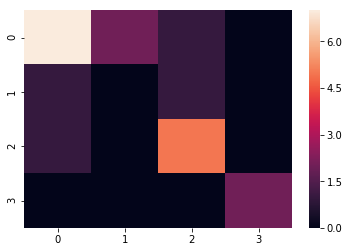

In [61]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [62]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4849785407725322

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [63]:
fleiss_kappa(anno.annotations[::])

0.47271045328399625

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [64]:
krippendorffs_alpha(anno.annotations[::])

0.7313648293963255

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [65]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.4857142857142857

In [66]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.48571429 0.39106901]
 [0.48571429 1.         0.55525606]
 [0.39106901 0.55525606 1.        ]]


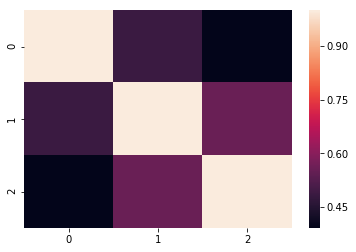

In [67]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [109]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [110]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [111]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

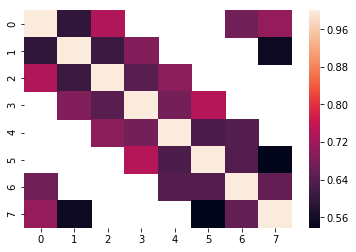

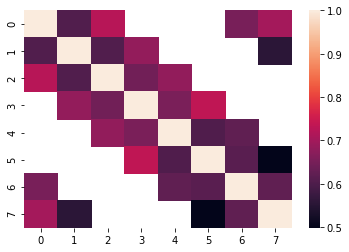

In [112]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [113]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [73]:
cat_int9 = np.loadtxt("../data/AnnotatedCategories.txt").transpose()
anno = AnnotationsContainer.from_array(cat_int9, missing_values=[-1])

In [74]:
anno.annotations

array([[1, 0, 1],
       [0, 0, 1],
       [2, 2, 3],
       [3, 3, 3],
       [1, 2, 2],
       [2, 5, 5],
       [2, 0, 0],
       [0, 1, 1],
       [0, 0, 1],
       [5, 2, 2],
       [2, 2, 2],
       [0, 0, 1],
       [0, 0, 0],
       [2, 2, 0],
       [0, 1, 1],
       [1, 4, 1],
       [5, 5, 5],
       [2, 2, 2],
       [2, 4, 4],
       [4, 2, 4],
       [2, 2, 2],
       [0, 0, 0],
       [4, 4, 4],
       [3, 3, 3],
       [0, 0, 2],
       [0, 2, 2],
       [4, 4, 1],
       [5, 5, 5],
       [4, 5, 4],
       [0, 0, 0]])

In [38]:
anno.labels

[1.0, 3.0, 5.0, 6.0, 7.0, 8.0]

In [39]:
pyanno.measures.agreement.labels_frequency(anno.annotations,6)

array([0.26666667, 0.14444444, 0.26666667, 0.07777778, 0.13333333,
       0.11111111])

[[7. 2. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 5. 0. 1. 1.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 1. 0. 2. 1.]
 [0. 0. 1. 0. 0. 2.]]


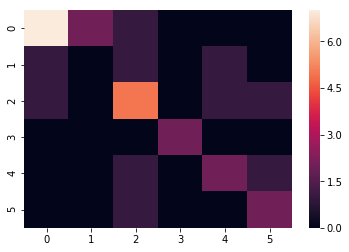

In [54]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],6)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [49]:
print("Scott's pi: {}\n".format(scotts_pi(anno.annotations[:,0], anno.annotations[:,1])))
print("Fleis's kappa: {}\n".format(fleiss_kappa(anno.annotations[::])))
print("Krippendorff's alpha: {}\n".format(krippendorffs_alpha(anno.annotations[::])))
print("Cohen's kappa: {}\n".format(cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])))

Scott's pi: 0.4849785407725322

Fleis's kappa: 0.47271045328399625

Krippendorff's alpha: 0.7313648293963255

Cohen's kappa: 0.4857142857142857



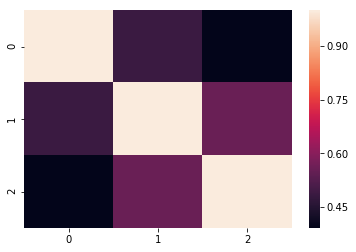

In [50]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
ax = seaborn.heatmap(m)
plt.show()

In [56]:
#define pairwise_metrics_average
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    

0.610720225458952

In [58]:
print("Pairwise Cohen's kappa:\n{}\n".format(pairwise_metric_average(cohens_kappa, anno.annotations)))
print("Pairwise Cohen's weighted kappa:\n{}\n".format(pairwise_metric_average(cohens_weighted_kappa,anno.annotations)))

Pairwise Cohen's kappa:
0.4773464541943107

Pairwise Cohen's weighted kappa:
0.610720225458952



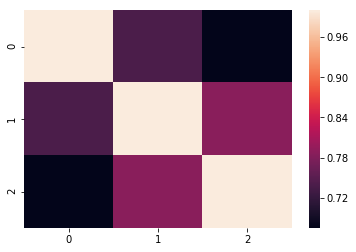

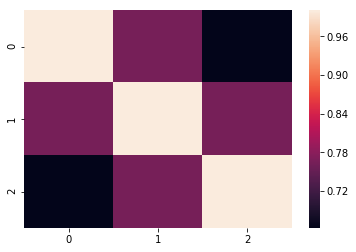

In [51]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

## Exercise 2 Memo:

For this exercise, I recruited three people to classify a total of 30 documents from Legislative Yuan interpellations into 8 pre-specified categories, namely ‘内政’ (Internal Administration), ‘社会福利及卫生环境’ (Social Welfare and Environmental Hygiene), ‘司法’ (Judiciary and Organic Laws and Statute), ‘交通’ (Transportation), ‘教育及文化’ (Education and Culture), ‘财政’ (Finance), ‘经济’ (Economics) and ‘外交与国防’ (Foreign and National Defense). This categorization is in alignment with the eight commitees of Legislative Yuan. Unfortunately, none of the 30 documents were classified as either ‘财政’ (Finance) or ‘外交与国防’ (Foreign and National Defense).

According to the statistics and heatmaps above, the Cohen's kappa map shows that the lowest pairwise score is around 0.45 (between coder 0 and coder 2), and the average is around 0.6. The pairwise Cohen's weighted kappa is 0.610720225458952. The Pearson's rho heat map and Spearman's rho heat map shows that the lowest pairwise rho score is around 0.66 (between coder 0 and coder 2), and the average is around 0.75.

According to the results, I would say that although the reliability of human assessment for this content is not too bad, there is still a large room of improvement. To increase the chance of getting the true class, we may either increase the number of coders or make adjustment to the categories.

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [78]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.72785395 0.21543505 0.04254331 0.01416769]
  [0.19530543 0.59184703 0.13594331 0.07690422]
  [0.03199028 0.14408911 0.65657076 0.16734985]
  [0.01156379 0.02570623 0.12559357 0.8371364 ]]

 [[0.52208098 0.27677874 0.13336475 0.06777552]
  [0.11510108 0.67253071 0.17451951 0.0378487 ]
  [0.05409803 0.2105845  0.52603911 0.20927836]
  [0.17341618 0.05058087 0.06990425 0.70609871]]

 [[0.81715722 0.09985954 0.04738656 0.03559668]
  [0.11079369 0.54841837 0.28882975 0.0519582 ]
  [0.05776011 0.09489986 0.64808496 0.19925507]
  [0.01941952 0.04316995 0.090618   0.84679252]]

 [[0.66945411 0.30156252 0.0219642  0.00701917]
  [0.14871755 0.58766167 0.25182728 0.0117935 ]
  [0.03786424 0.18121837 0.53572182 0.24519557]
  [0.00491135 0.0477699  0.20913945 0.7381793 ]]

 [[0.839987   0.11293527 0.01180643 0.0352713 ]
  [0.13826855 0.72018306 0.09805357 0.04349483]
  [0.13053549 0.12299789 0.57865029 0.16781633]
  [0.02324186 0.09643929 0.07717088 0.80314797]]

 [[0.75283298 0.17721995 0.061

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [79]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [80]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Uncomment the cell below if you would rather train by MLE.

In [81]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [82]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [83]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x7fc646beaa20>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fc646beab00>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc62745a208>))

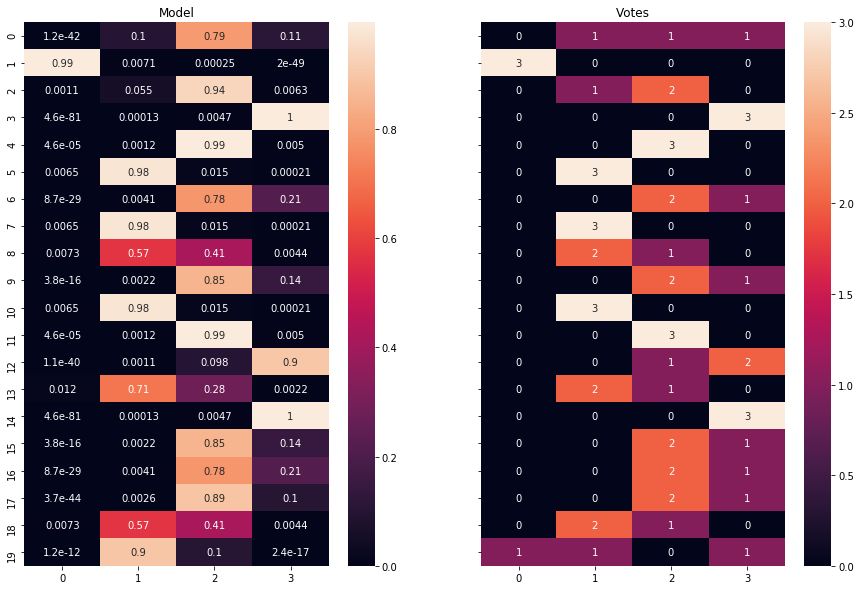

In [84]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [85]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.63833902 0.72430822 0.65875868 0.90179723 0.69685692 0.6902568
 0.89274849 0.92856265]
-3091.412743699516


In [86]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79129504 0.74072282 0.76229069 0.72523619 0.71645493 0.71856861
 0.77320636 0.71660061]
-2811.9462093229304


In [87]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.81094052, 0.70645315, 0.82208852, ..., 0.69264543, 0.80729258,
        0.68022996],
       [0.81094052, 0.70645315, 0.82208852, ..., 0.69264543, 0.80729258,
        0.68022996],
       [0.83865582, 0.74983185, 0.81374469, ..., 0.73002894, 0.75814092,
        0.66965828],
       ...,
       [0.7111208 , 0.70769621, 0.79238274, ..., 0.75845176, 0.74845189,
        0.77244702],
       [0.72622452, 0.69263893, 0.77389718, ..., 0.74399281, 0.82148013,
        0.67259991],
       [0.72622452, 0.69263893, 0.77389718, ..., 0.74399281, 0.82148013,
        0.67259991]])

In [88]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01110452 0.28930055 0.36487576 0.33471917]
 [0.99022558 0.00241836 0.00404792 0.00330814]
 [0.00250056 0.05510046 0.93456428 0.0078347 ]
 ...
 [0.00253004 0.04395921 0.94558367 0.00792707]
 [0.00249501 0.00571472 0.93249001 0.05930027]
 [0.03189453 0.93881253 0.01611941 0.01317352]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x7fc6272f3748>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fc6272f3400>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc6272a4978>))

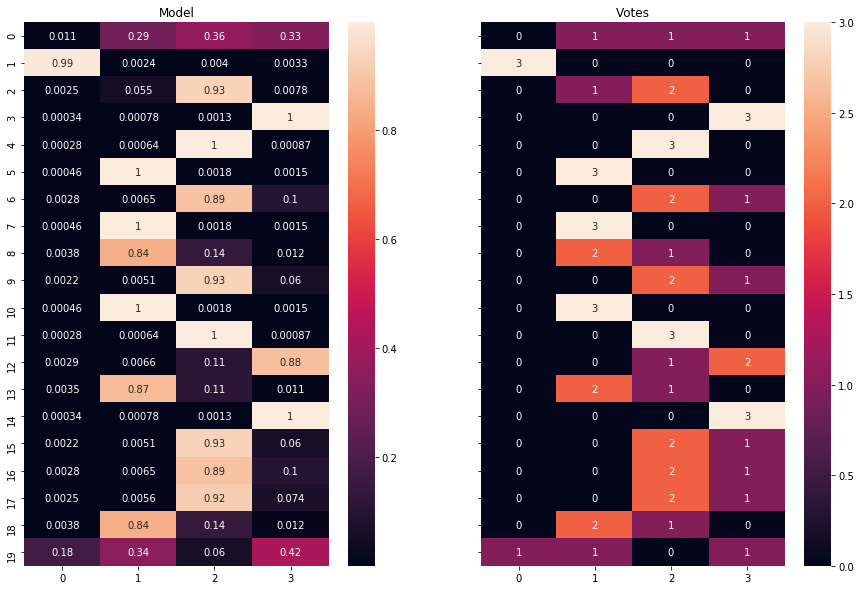

In [89]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [90]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

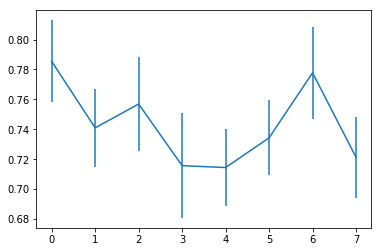

In [91]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [92]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [93]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

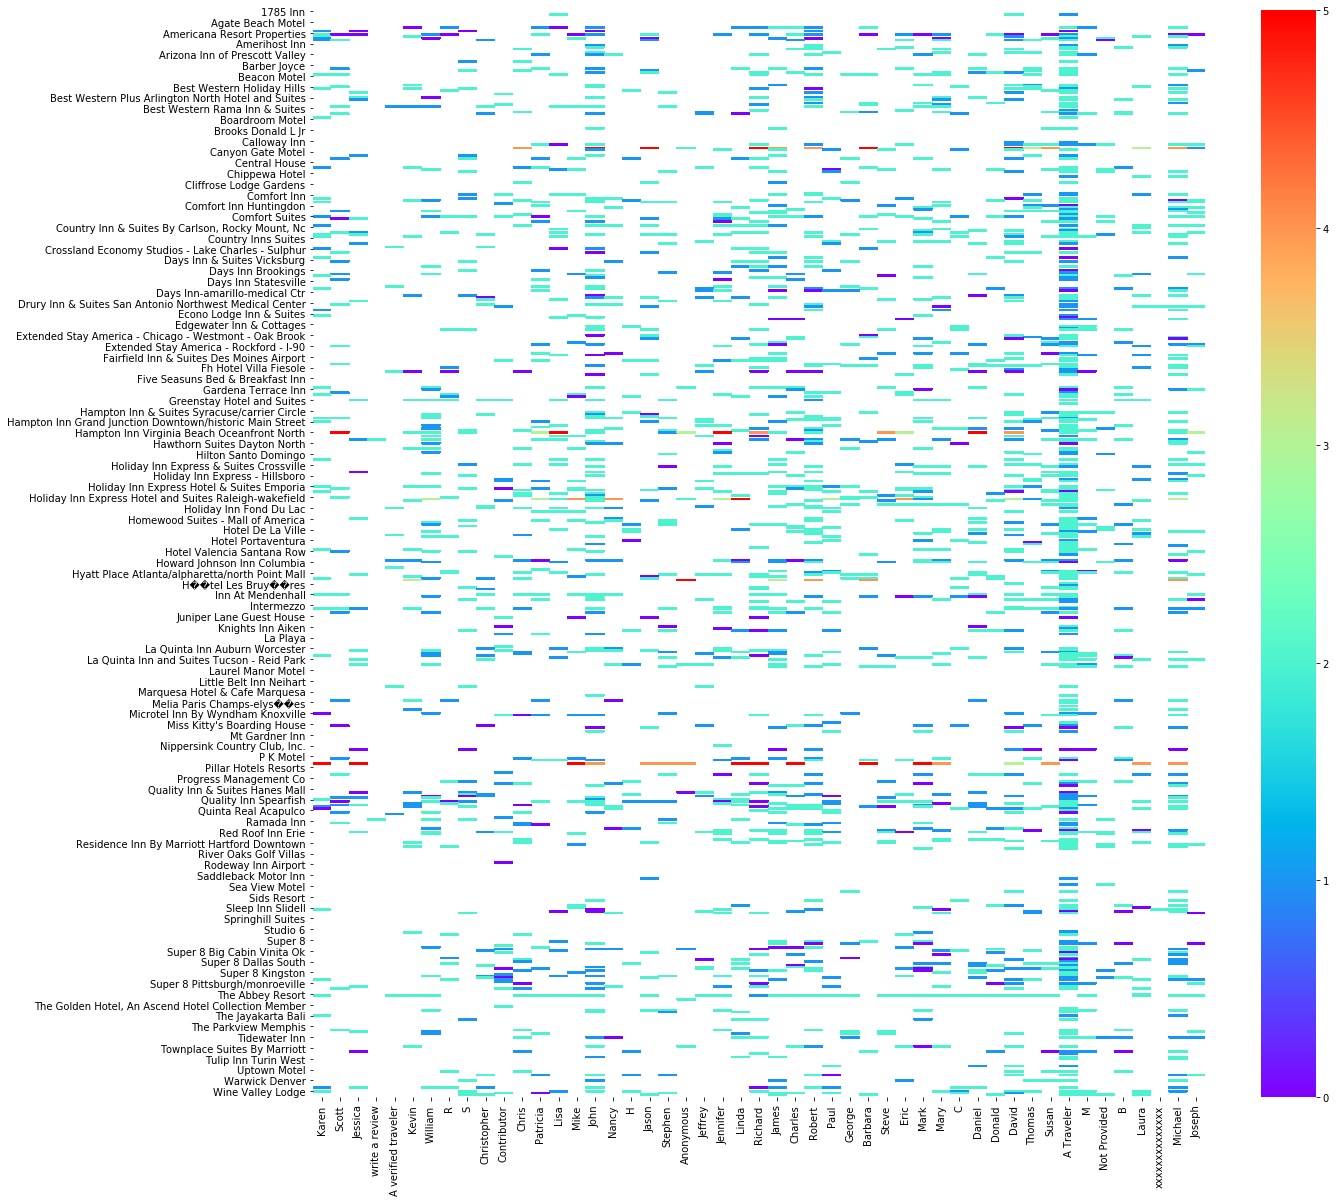

In [94]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [95]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [96]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [97]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [98]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [99]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


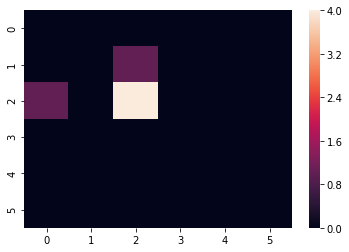

In [100]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [101]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [102]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [103]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

/home/lingdai/.local/lib/python3.6/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


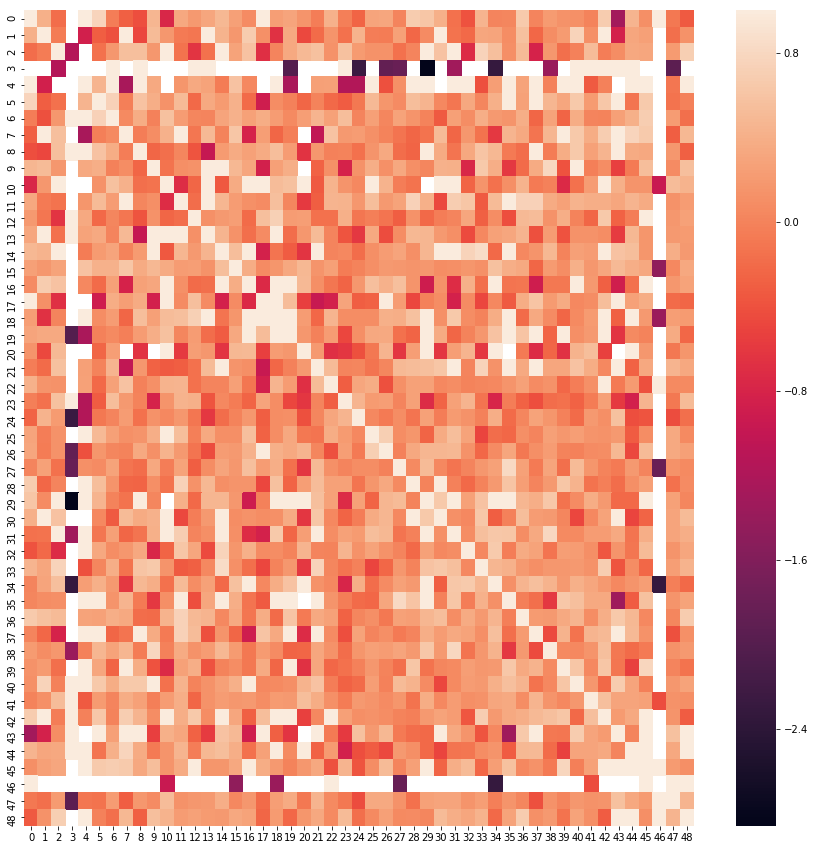

In [104]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [105]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

-2733.4352517845264


(<matplotlib.figure.Figure at 0x7fc62752f320>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fc627114518>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc626f96cc0>))

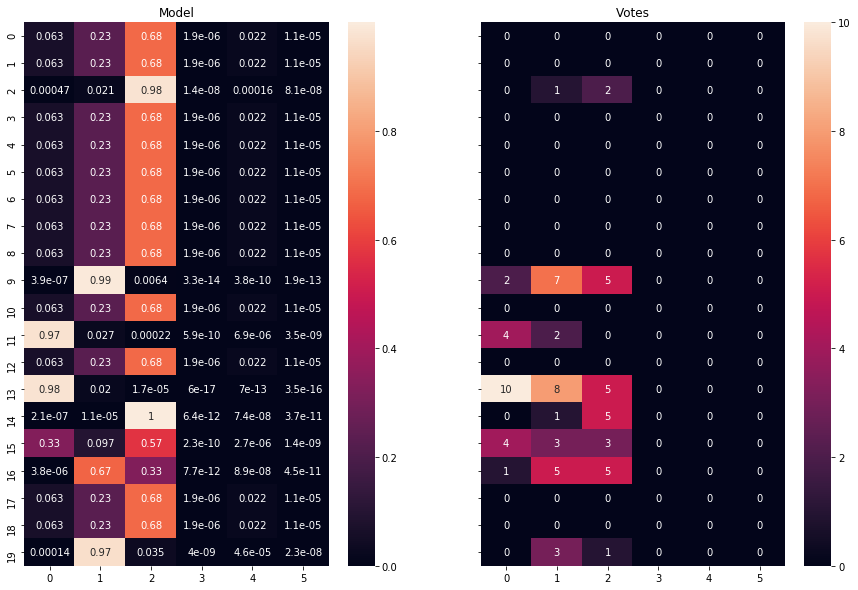

In [106]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

In [119]:
cat_int9 = np.loadtxt("../data/AnnotatedCategories.txt").transpose()
anno1 = AnnotationsContainer.from_array(cat_int9, missing_values=[-1])
model1 = ModelB.create_initial_state(8,3)

In [118]:
samples = model1.sample_posterior_over_accuracy(anno1.annotations, 200, burn_in_samples=100, thin_samples=3)
model1.map(anno1.annotations)

/home/lingdai/.local/lib/python3.6/site-packages/pyanno/util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


In [117]:
posterior = model1.infer_labels(anno1.annotations)

(<matplotlib.figure.Figure at 0x7fc62427df60>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fc6242968d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc6242536d8>))

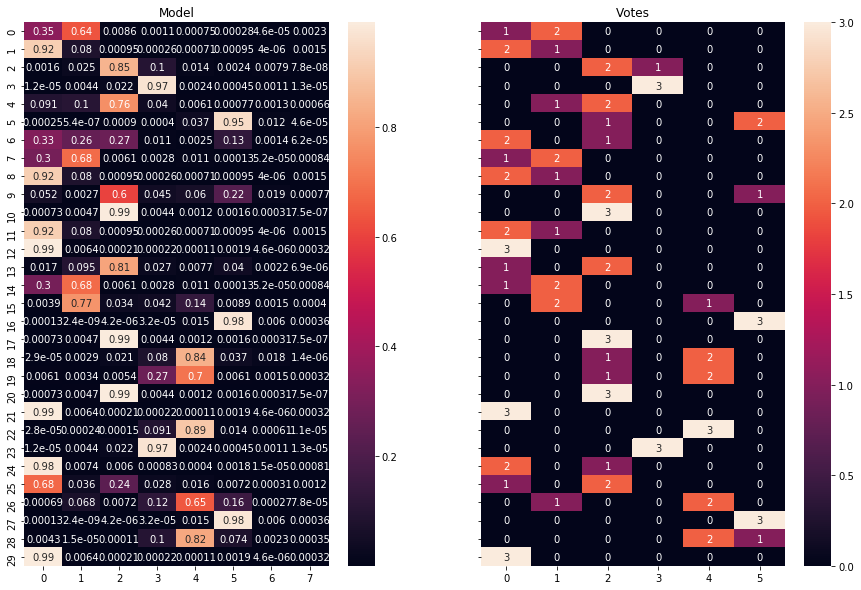

In [122]:
def makeQuestionComparison(model, anno_target, num_questions = 30):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

makeQuestionComparison(model1, anno1)

In [120]:
#Try ModelBt
model2 = ModelBt.create_initial_state(8,3)
model2.mle(anno1.annotations)
samples = model2.sample_posterior_over_accuracy(anno1.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

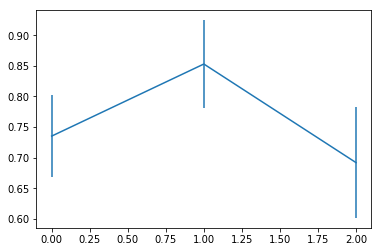

In [121]:
plt.figure()
plt.errorbar(range(3),y, yerr = y_ci)
plt.show()

## Exercise 3 Memo

For exercise 3, we continued to use the same data used in exercise 2.

Among the 30 questions, the three coders were able to reach full agreement on 11 questions, and none of the questions received more than two different answers. Coders tend to confuse ‘内政’ (Internal Administration) with ‘社会福利及卫生环境’ (Social Welfare and Environmental Hygiene) or ‘司法’ (Judiciary and Organic Laws and Statute) most frequently. According to the results generated by ModelB, the true class for question 6 is sure, with almost equal probablities distributed across class 1-3, which stand for ‘内政’ (Internal Administration), ‘社会福利及卫生环境’ (Social Welfare and Environmental Hygiene), and ‘司法’ (Judiciary and Organic Laws and Statute) respectively.

Among the three coders, the second coder (coder 1) seems to have the highest skills, with an accuracy of around 85%, followed by coder 0, with an accuracy of around 74%, and coder 3, with an accuracy of around 70%.